In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Generic python
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
import odc.algo

# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import datacube

CMAP = "Blues"

import dask
from dask.distributed import Client

import odc.algo

assert(xr.__version__ == "0.15.0")
assert(dask.__version__ == "2.12.0")

client = Client('dask-scheduler.dask.svc.cluster.local:8786')

client.get_versions(check=True)
client

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 3 Cores: 24 Memory: 101.19 GB


# Land Change

This notebook uses changes in Fractional Cover to identify land change. The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral parameters in each of those time periods.

Fractional Cover represents teh proportion of the land surface which is bare (BS), covered by photosynthetic vegetation (PV), or non-photosynthetic vegetation(NPV). 

The Fractional Cover product was generated using the spectral unmixing algorithm developed by the Joint Remote Sensing Research Program (JRSRP) which used the spectral signature for each pixel to break it up into three fractions, based on field work that determined the spectral characteristics of these fractions. The fractions were retrieved by inverting multiple linear regression estimates and using synthetic endmembers in a constrained non-negative least squares unmixing model.

The green (PV) fraction includes leaves and grass, the non-photosynthetic fraction (NPV) includes branches, dry grass and dead leaf litter, and the bare soil (BS) fraction includes bare soil or rock.

Changes in each fraction are conincident with land change.

In some cases these changes could be deforestation. Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. In most cases, these algorithms can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments.

This output of this notebook is a raster product for each of the fractional cover bands - where positive changes represents gain in that band, and negative change represents loss. 

In [2]:
# The dtip fork of datacude_utilities includes some updated requirements which we need for the notebook to run on the updated dask cluster
#!pip install git+https://github.com/dtip/datacube-utilities.git#egg=datacube_utilities
#!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

In [3]:
dc = datacube.Datacube(app = 'land_degredation')#, config = '/home/localuser/.datacube.conf')

from matplotlib.cm import RdYlGn, Greens
from odc.algo import to_f32, from_float, xr_geomedian
from datacube_utilities.dc_load import get_product_extents
from datacube_utilities.dc_time import dt_to_str
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from datacube_utilities.dc_rgb import rgb
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.createindices import NDVI
from datacube_utilities.fromDCALscripts import threshold_plot
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
from datacube_utilities.dc_utilities import write_geotiff_from_xr


In [4]:
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

## Set Variables

In [5]:
#inputs
#options "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4" and "SENTINEL_2"
platform_base = "LANDSAT_8"
platform_analysis = "LANDSAT_8"
#For Fiji this should be the only option - may change for Solomon and Vanuatu
output_projection = "EPSG:3460"
crs = "EPSG:3460"
res = (30)

# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

#set baseline start and end of period
baseline_start_date = '2013-1-1'
baseline_end_date = '2014-1-1'

#set the analysis start and end of period
analysis_start_date = '2018-1-1'
analysis_end_date = '2019-1-1'

#define AOI
#central area - do dates 2013- 2014 and 2018-2019
aoi_wkt = "POLYGON ((177.42576599121094 -18.058395415674948, 177.5390625 -18.058395415674948, 177.5390625 -17.96567026450931, 177.42576599121094 -17.96567026450931, 177.42576599121094 -18.058395415674948))"
# wakaya island - hit by cyclone winston in feb 2016  - dates end of JAn 2015-2016, start of March 2016 - 2017
#aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"

## create AOI

In [6]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")

In [7]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [8]:
## The code below renders a map that can be used to orient yourself with the region.
#display_map(latitude = lat_extents, longitude = lon_extents)

In [9]:
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")

In [10]:
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)

In [11]:
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)

In [12]:
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)

In [13]:
print(lat_extents)

(-18.058395415674948, -17.96567026450931)


In [14]:
print(lat_range)

(3882373.0581493354, 3892718.536114537)


## Translate inputs and load data

In [15]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls8_usgs_sr_scene'
        water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product, measurements, water_product

In [16]:
baseline_product, baseline_measurement, baseline_water_product = create_product_measurement(platform_base)
analysis_product, analysis_measurement, analysis_water_product = create_product_measurement(platform_analysis)

In [17]:
#create resolution
resolution = (-res, res)

In [18]:
dask_chunks = dict(
    time = 10,
    x = 500,
    y = 500
)

In [19]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)
analysis_time_period = createDate(analysis_start_date, analysis_end_date)

In [20]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_range,
    'x': lon_range,
    'output_crs': output_projection,  
    'resolution': resolution,
    'dask_chunks': dask_chunks
}

In [21]:
%%time
baseline_ds = dc.load(
    time = baseline_time_period,
    measurements = baseline_measurement,
    product = baseline_product,
    platform = platform_base,
    crs = crs,
    **query
)
baseline_ds

CPU times: user 218 ms, sys: 3.45 ms, total: 221 ms
Wall time: 270 ms


In [22]:
%%time
analysis_ds = dc.load(
    time = analysis_time_period,
    measurements = analysis_measurement,
    product = analysis_product,
    platform = platform_analysis,
    crs = crs,
    **query
)
analysis_ds

CPU times: user 355 ms, sys: 19 ms, total: 374 ms
Wall time: 414 ms


> #### Check if loads are valid

In [23]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [24]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [25]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

> #### Clean Data
> Generating boolean masks that highlight valid pixels
> Pixels must be cloud-free over land or water to be considered

In [26]:
def look_up_clean(platform, ds):
    if platform  in ["SENTINEL_2"]:
        good_quality = (
            (ds.scene_classification == 4) | # clear
            (ds.scene_classification == 5) | 
            (ds.scene_classification == 7) | 
            (ds.scene_classification == 2) | 
            (ds.scene_classification == 6)  #water
        )
    elif platform in ["LANDSAT_8"]:  
        good_quality = (
            (ds.pixel_qa == 322)  | # clear
            (ds.pixel_qa == 386)  |
            (ds.pixel_qa == 834)  |
            (ds.pixel_qa == 898)  |
            (ds.pixel_qa == 1346) |
            (ds.pixel_qa == 324)  | # water
            (ds.pixel_qa == 388)  |
            (ds.pixel_qa == 836)  |
            (ds.pixel_qa == 900)  |
            (ds.pixel_qa == 1348)
        )
    elif platform in ["LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:    
        good_quality = (
            (ds.pixel_qa == 66)  | # clear
            (ds.pixel_qa == 130) |
            (ds.pixel_qa == 68)  | # water
            (ds.pixel_qa == 132)  
        )
    else:
        print("invalid platform")
    return good_quality

In [27]:
%%time
baseline_clean_mask = look_up_clean(platform_base, baseline_ds)
analysis_clean_mask = look_up_clean(platform_analysis, analysis_ds)

CPU times: user 60.3 ms, sys: 4.03 ms, total: 64.3 ms
Wall time: 63.6 ms


In [28]:
%%time
xx_data_b = baseline_ds[allmeasurements]
xx_data_a = analysis_ds[allmeasurements]

CPU times: user 221 µs, sys: 40 µs, total: 261 µs
Wall time: 270 µs


In [29]:
xx_clean_b = odc.algo.keep_good_only(xx_data_b, where=baseline_clean_mask)
xx_clean_b

<xarray.Dataset>
Dimensions:  (time: 29, x: 398, y: 346)
Coordinates:
  * x        (x) float64 1.86e+06 1.86e+06 1.86e+06 ... 1.872e+06 1.872e+06
  * y        (y) float64 3.893e+06 3.893e+06 3.893e+06 ... 3.882e+06 3.882e+06
  * time     (time) datetime64[ns] 2013-04-25T22:14:33 ... 2013-12-30T22:08:25
Data variables:
    green    (time, y, x) int16 dask.array<chunksize=(10, 346, 398), meta=np.ndarray>
    red      (time, y, x) int16 dask.array<chunksize=(10, 346, 398), meta=np.ndarray>
    blue     (time, y, x) int16 dask.array<chunksize=(10, 346, 398), meta=np.ndarray>
    nir      (time, y, x) int16 dask.array<chunksize=(10, 346, 398), meta=np.ndarray>
    swir1    (time, y, x) int16 dask.array<chunksize=(10, 346, 398), meta=np.ndarray>
    swir2    (time, y, x) int16 dask.array<chunksize=(10, 346, 398), meta=np.ndarray>
Attributes:
    crs:      EPSG:3460

In [30]:
xx_clean_a = odc.algo.keep_good_only(xx_data_a, where=analysis_clean_mask)
xx_clean_a

<xarray.Dataset>
Dimensions:  (time: 69, x: 398, y: 346)
Coordinates:
  * x        (x) float64 1.86e+06 1.86e+06 1.86e+06 ... 1.872e+06 1.872e+06
  * y        (y) float64 3.893e+06 3.893e+06 3.893e+06 ... 3.882e+06 3.882e+06
  * time     (time) datetime64[ns] 2018-01-01T22:12:57 ... 2018-12-28T22:06:54
Data variables:
    green    (time, y, x) int16 dask.array<chunksize=(10, 346, 398), meta=np.ndarray>
    red      (time, y, x) int16 dask.array<chunksize=(10, 346, 398), meta=np.ndarray>
    blue     (time, y, x) int16 dask.array<chunksize=(10, 346, 398), meta=np.ndarray>
    nir      (time, y, x) int16 dask.array<chunksize=(10, 346, 398), meta=np.ndarray>
    swir1    (time, y, x) int16 dask.array<chunksize=(10, 346, 398), meta=np.ndarray>
    swir2    (time, y, x) int16 dask.array<chunksize=(10, 346, 398), meta=np.ndarray>
Attributes:
    crs:      EPSG:3460

In [31]:
%%time
scale, offset = (1/10_000, 0)  # differs per product, aim for 0-1 values in float32
xx_clean_b_32 = to_f32(xx_clean_b, scale=scale, offset=offset)
yy_b = xr_geomedian(xx_clean_b_32, 
                  num_threads=1,  # disable internal threading, dask will run several concurrently
                  eps=0.2*scale,  # 1/5 pixel value resolution
                  nocheck=True)   # disable some checks inside geomedian library that use too much ram

baseline_composite = from_float(yy_b, 
                dtype='int16', 
                nodata=-9999, 
                scale=1/scale, 
                offset=-offset/scale)
baseline_composite

CPU times: user 970 ms, sys: 180 ms, total: 1.15 s
Wall time: 1.15 s


In [32]:
%%time
xx_clean_a_32 = to_f32(xx_clean_a, scale=scale, offset=offset)
yy_a = xr_geomedian(xx_clean_a_32, 
                  num_threads=1,  # disable internal threading, dask will run several concurrently
                  eps=0.2*scale,  # 1/5 pixel value resolution
                  nocheck=True)   # disable some checks inside geomedian library that use too much ram

analysis_composite = from_float(yy_a, 
                dtype='int16', 
                nodata=-9999, 
                scale=1/scale, 
                offset=-offset/scale)
analysis_composite

CPU times: user 36.3 ms, sys: 7.33 ms, total: 43.7 ms
Wall time: 43.1 ms


>#### Mosaic
> Use clean masks in a time series composite

## Mask Water New

In [33]:
%%time
#when S2 mask is ready - can remove the if statement. 
if platform_base in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes_base = dc.load(product=baseline_water_product,
            measurements = ["water_classification"],
            time = baseline_time_period,
            platform = platform_base, 
            crs = crs,
               **query)
    #change clouds to no data value
    water_classes_base = water_scenes_base.where(water_scenes_base >= 0)
elif platform_base in ["SENTINEL_2"]:
    water_classes_base = dask.delayed(wofs_classify)(baseline_ds, clean_mask=baseline_clean_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes_base = dask.delayed(water_classes_base.rename({'wofs': 'water_classification'}))

water_scenes_base

CPU times: user 143 ms, sys: 3.7 ms, total: 146 ms
Wall time: 165 ms


In [34]:
%%time
#when S2 mask is ready - can remove the if statement. 
if platform_analysis in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes_analysis = dc.load(product=analysis_water_product,
            measurements = ["water_classification"],
            time = analysis_time_period,
            platform = platform_analysis,  
            crs = crs,
               **query)
    #change clouds to no data value
    water_classes_analysis = water_scenes_analysis.where(water_scenes_analysis >= 0)
elif platform_analysis in ["SENTINEL_2"]:
    water_classes_analysis = dask.delayed(wofs_classify)(analysis_ds, clean_mask=analysis_clean_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes_analysis = dask.delayed(water_classes_analysis.rename({'wofs': 'water_classification'}))

water_scenes_analysis

CPU times: user 286 ms, sys: 14.1 ms, total: 300 ms
Wall time: 325 ms


## mask water


In [35]:
water_composite_base = water_classes_base.water_classification.mean(dim='time')
water_composite_base

<xarray.DataArray 'water_classification' (y: 346, x: 398)>
dask.array<mean_agg-aggregate, shape=(346, 398), dtype=float64, chunksize=(346, 398), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 3.893e+06 3.893e+06 3.893e+06 ... 3.882e+06 3.882e+06
  * x        (x) float64 1.86e+06 1.86e+06 1.86e+06 ... 1.872e+06 1.872e+06

In [36]:
water_composite_analysis = water_classes_analysis.water_classification.mean(dim='time')
water_composite_analysis

<xarray.DataArray 'water_classification' (y: 346, x: 398)>
dask.array<mean_agg-aggregate, shape=(346, 398), dtype=float64, chunksize=(346, 398), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 3.893e+06 3.893e+06 3.893e+06 ... 3.882e+06 3.882e+06
  * x        (x) float64 1.86e+06 1.86e+06 1.86e+06 ... 1.872e+06 1.872e+06

In [37]:
%%time
baseline_composite = baseline_composite.rename({"y": "latitude", "x":"longitude"})
water_composite_base = water_composite_base.rename({"y": "latitude", "x":"longitude"})
analysis_composite = analysis_composite.rename({"y": "latitude", "x":"longitude"})
water_composite_analysis = water_composite_analysis.rename({"y": "latitude", "x":"longitude"})

CPU times: user 2.01 ms, sys: 0 ns, total: 2.01 ms
Wall time: 2.02 ms


>## Plot a spectral index using the cloud-filtered mosaic

# Spectral Parameter Anomaly

In [38]:
%%time
parameter_baseline_composite = xr.map_blocks(frac_coverage_classify, baseline_composite, kwargs={"no_data": np.nan})
parameter_analysis_composite = xr.map_blocks(frac_coverage_classify, analysis_composite, kwargs={"no_data": np.nan})

CPU times: user 38.5 ms, sys: 3.73 ms, total: 42.2 ms
Wall time: 41.3 ms


## Apply water mask


In [39]:
%%time
frac_cov_baseline = parameter_baseline_composite.where((water_composite_base <= 0.4) & (parameter_baseline_composite !=-9999))

CPU times: user 15.9 ms, sys: 0 ns, total: 15.9 ms
Wall time: 15.7 ms


In [40]:
%%time
frac_cov_analysis = parameter_analysis_composite.where((water_composite_analysis <= 0.4) & (parameter_analysis_composite !=-9999))

CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 15.2 ms


In [41]:
%%time
parameter_anomaly = frac_cov_analysis - frac_cov_baseline

CPU times: user 4.72 ms, sys: 132 µs, total: 4.85 ms
Wall time: 4.82 ms


In [42]:
%%time
parameter_anomaly_output = parameter_anomaly.compute()

CPU times: user 1.56 s, sys: 110 ms, total: 1.67 s
Wall time: 2min 39s


# Export Product

In [43]:
bs_output = parameter_anomaly_output.bs
pv_output = parameter_anomaly_output.pv
npv_output = parameter_anomaly_output.npv

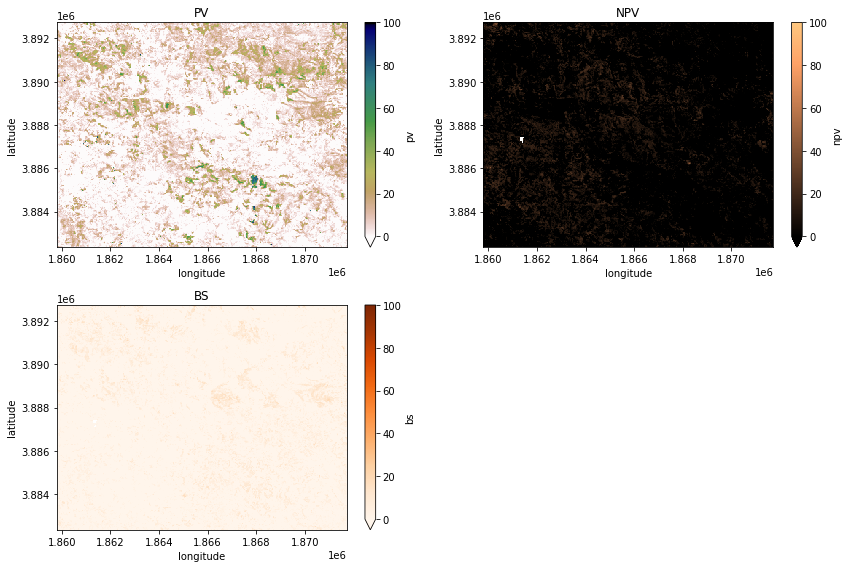

In [44]:
#plot the parameter anomaly. 
scene = 0
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
parameter_anomaly_output.pv.plot(cmap='gist_earth_r', vmin = 0, vmax = 100)
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
parameter_anomaly_output.bs.plot(cmap='Oranges', vmin = 0, vmax = 100)
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
parameter_anomaly_output.npv.plot(cmap='copper', vmin = 0, vmax = 100)
ax3.set_title('NPV')

plt.tight_layout()
plt.show()

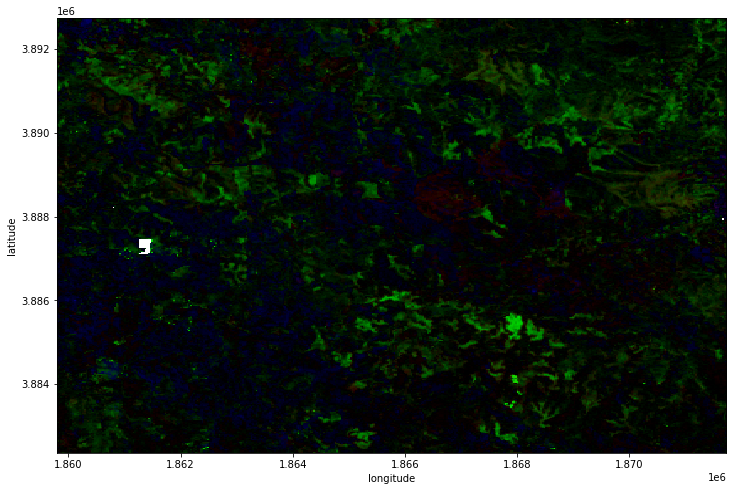

In [45]:
# Plot parameter anomaly as cloud free RGB image 
parameter_anomaly_output[['bs','pv','npv']].to_array().plot.imshow(
    #col='time',
    figsize=(12, 8),
    vmin=0,
    vmax=100
);

In [46]:
write_geotiff_from_xr('land_change.tiff', parameter_anomaly_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')

In [47]:
write_geotiff_from_xr('bs_change.tiff', bs_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')
write_geotiff_from_xr('pv_change.tiff', pv_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')
write_geotiff_from_xr('npv_change.tiff', npv_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')